# Install Dependencies

In [1]:
!pip install tensorflow==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-gpu==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [5]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [7]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [8]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15279648372144840809
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16204339908843643395
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [9]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [10]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [12]:

#Uncompress Tar GZ Labelled Faces in the Wild Dataset

!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

#### Positive collection from webcam

In [14]:
# importing uuid library to geenrate unique image names
import uuid

In [15]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [16]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Load and Preprocess Images

#### Get images directories

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'data\\anchor\\07f1308a-2f0b-11f0-aead-c423607b4a5c.jpg'


#### Preprocessing - Scale and Resize

In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [24]:
img = preprocess(dir_test.next())

In [25]:
img.numpy().max()

1.0

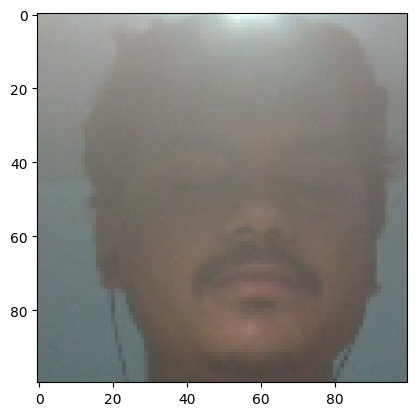

In [26]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [27]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [28]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

(b'data\\anchor\\07bcea6e-2f0b-11f0-9cc4-c423607b4a5c.jpg',
 b'data\\positive\\fe8d4fc1-2f0a-11f0-9973-c423607b4a5c.jpg',
 1.0)